In [1]:
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import VGG16, InceptionResNetV2, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA


In [2]:
# Function to extract frames from a video
def extract_frames(video_path, frame_rate):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_interval = int(fps / frame_rate)  # Sample frames every 'frame_interval' frames
    
    success, frame = cap.read()
    count = 0
    
    while success:
        if count % frame_interval == 0:
            frames.append(frame)
        success, frame = cap.read()
        count += 1
    
    cap.release()
    return frames

In [3]:
# Function to preprocess frames for CNNs
def preprocess_frame_for_cnn(frame, model_name='vgg'):
    frame = cv2.resize(frame, (224, 224))  # Resize to fit CNN input dimensions
    img_array = image.img_to_array(frame)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Use the appropriate preprocess function for the model
    if model_name == 'vgg':
        return vgg_preprocess_input(img_array)
    elif model_name == 'inception':
        return inception_preprocess_input(img_array)
    else:
        raise ValueError("Invalid model name. Choose 'vgg' or 'inception'.")

In [4]:
# Feature extraction using CNNs
def extract_features(frames, model, model_name='vgg'):
    features = []
    for frame in frames:
        img_data = preprocess_frame_for_cnn(frame, model_name)
        feature_vector = model.predict(img_data)
        features.append(feature_vector.flatten())
    return np.array(features)

In [5]:
# CNN Model for feature extraction (VGG16, InceptionResNetV2, etc.)
def create_cnn_model(model_name='vgg'):
    if model_name == 'vgg':
        base_model = VGG16(weights='imagenet', include_top=False)  # You can replace with InceptionResNetV2, etc.
    elif model_name == 'inception':
        base_model = InceptionV3(weights='imagenet', include_top=False)
    else:
        raise ValueError("Invalid model name. Choose 'vgg' or 'inception'.")
    
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

In [6]:
# Sparse Autoencoder for feature compression
def sparse_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu', activity_regularizer='l1')(input_layer)  # Add sparsity constraint
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder, encoder

In [7]:
# Frame classification (Keyframe selection) using Random Forest
def classify_keyframes(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Classify keyframes
    keyframes = clf.predict(X_test)
    return keyframes

In [8]:
# Main video summarization process
def video_summarization(video_path, model_name='vgg'):
    frame_rate = 1  # Extract 1 frame per second
    frames = extract_frames(video_path, frame_rate)
    
    # Feature extraction using CNN
    cnn_model = create_cnn_model(model_name)
    features = extract_features(frames, cnn_model, model_name)
    
    # Dimensionality reduction using Sparse Autoencoder
    autoencoder, encoder = sparse_autoencoder(features.shape[1])
    autoencoder.fit(features, features, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)
    compressed_features = encoder.predict(features)
    
    # Keyframe classification
    # Assuming labels are available (0: non-keyframe, 1: keyframe)
    # You might need a labeled dataset or manual labeling for this part
    labels = np.random.randint(0, 2, len(compressed_features))  # Dummy labels, replace with actual
    keyframes = classify_keyframes(compressed_features, labels)
    
    # Select keyframes
    keyframe_indices = np.where(keyframes == 1)[0]
    keyframe_images = [frames[i] for i in keyframe_indices]
    
    # Return or save keyframes
    for idx, keyframe in enumerate(keyframe_images):
        cv2.imwrite(f"keyframe_{idx}.jpg", keyframe)

In [9]:
# Run the video summarization
video_path = 'Downloads/vid1.1.mp4'
video_summarization(video_path, model_name='vgg')  # You can use 'vgg' or 'inception' here

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 166.5338 - val_loss: 80.0770
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 73.9152 - val_loss: 80.0463
Epoch 3/50
1/1

In [10]:
def create_summary_video(keyframe_images, output_video_path, fps=1, frame_size=(224, 224)):
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    for keyframe in keyframe_images:
        # Resize keyframe to the correct frame size
        resized_frame = cv2.resize(keyframe, frame_size)
        out.write(resized_frame)

    out.release()

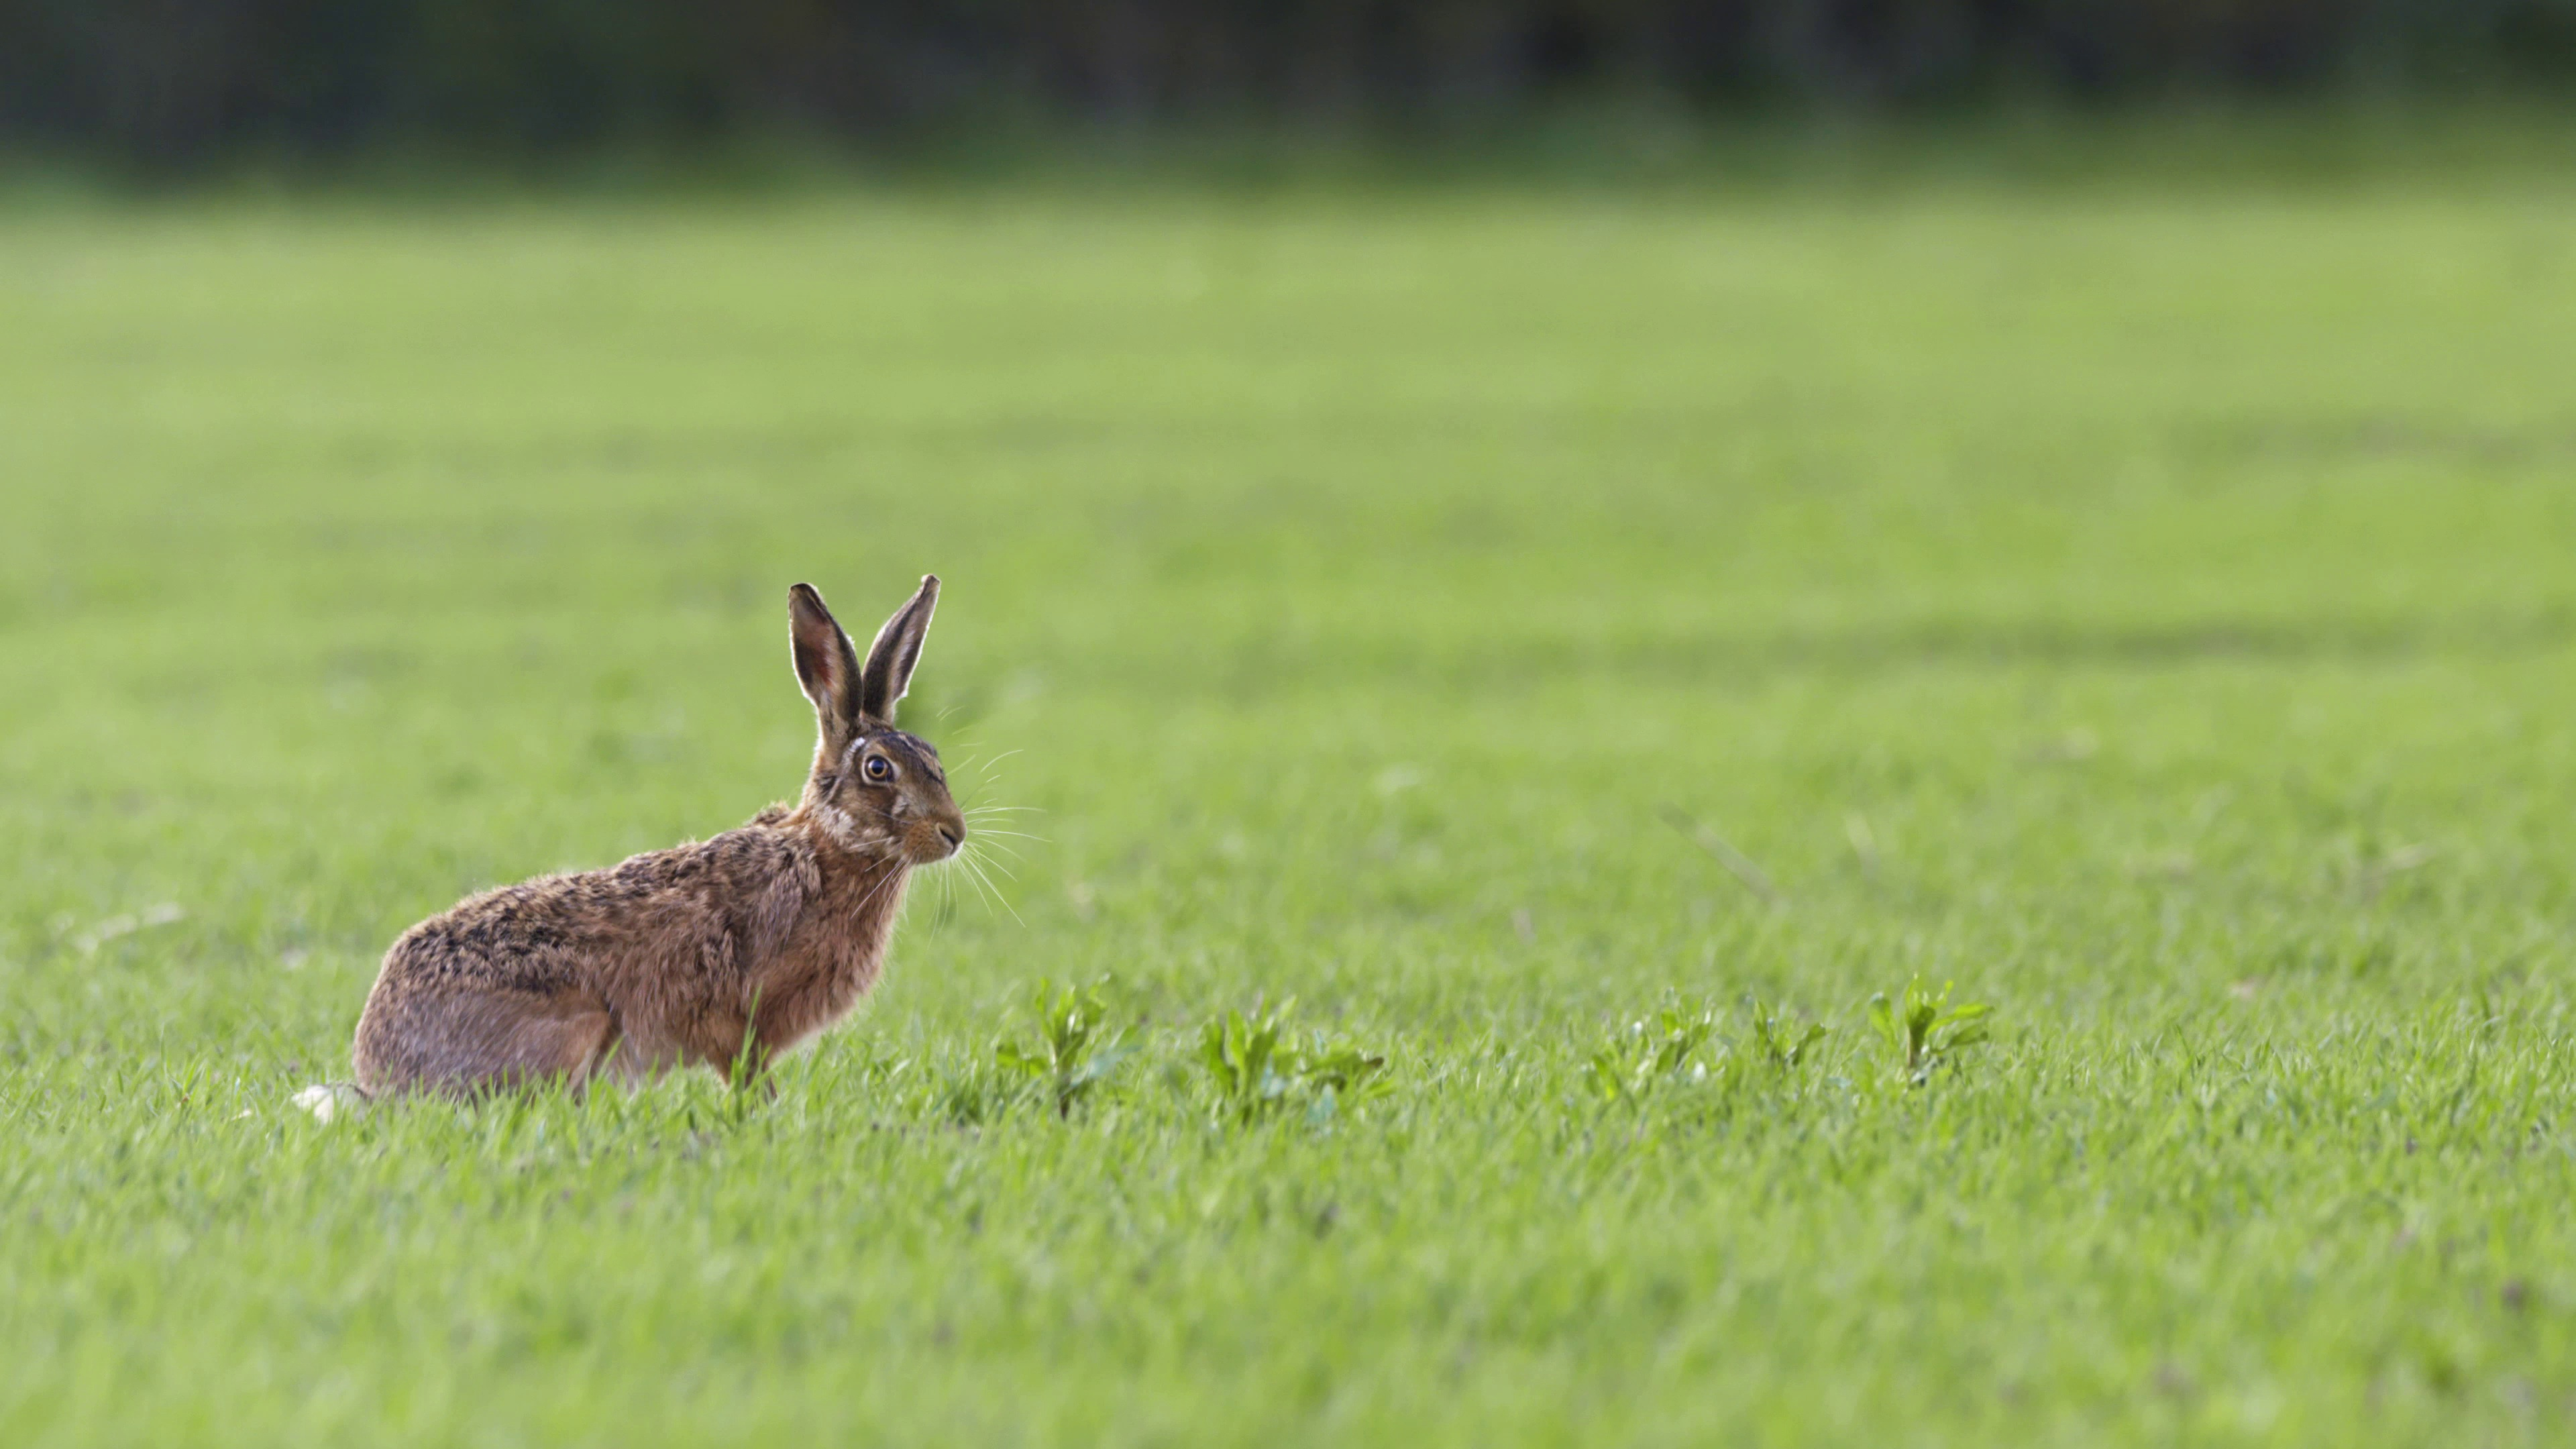

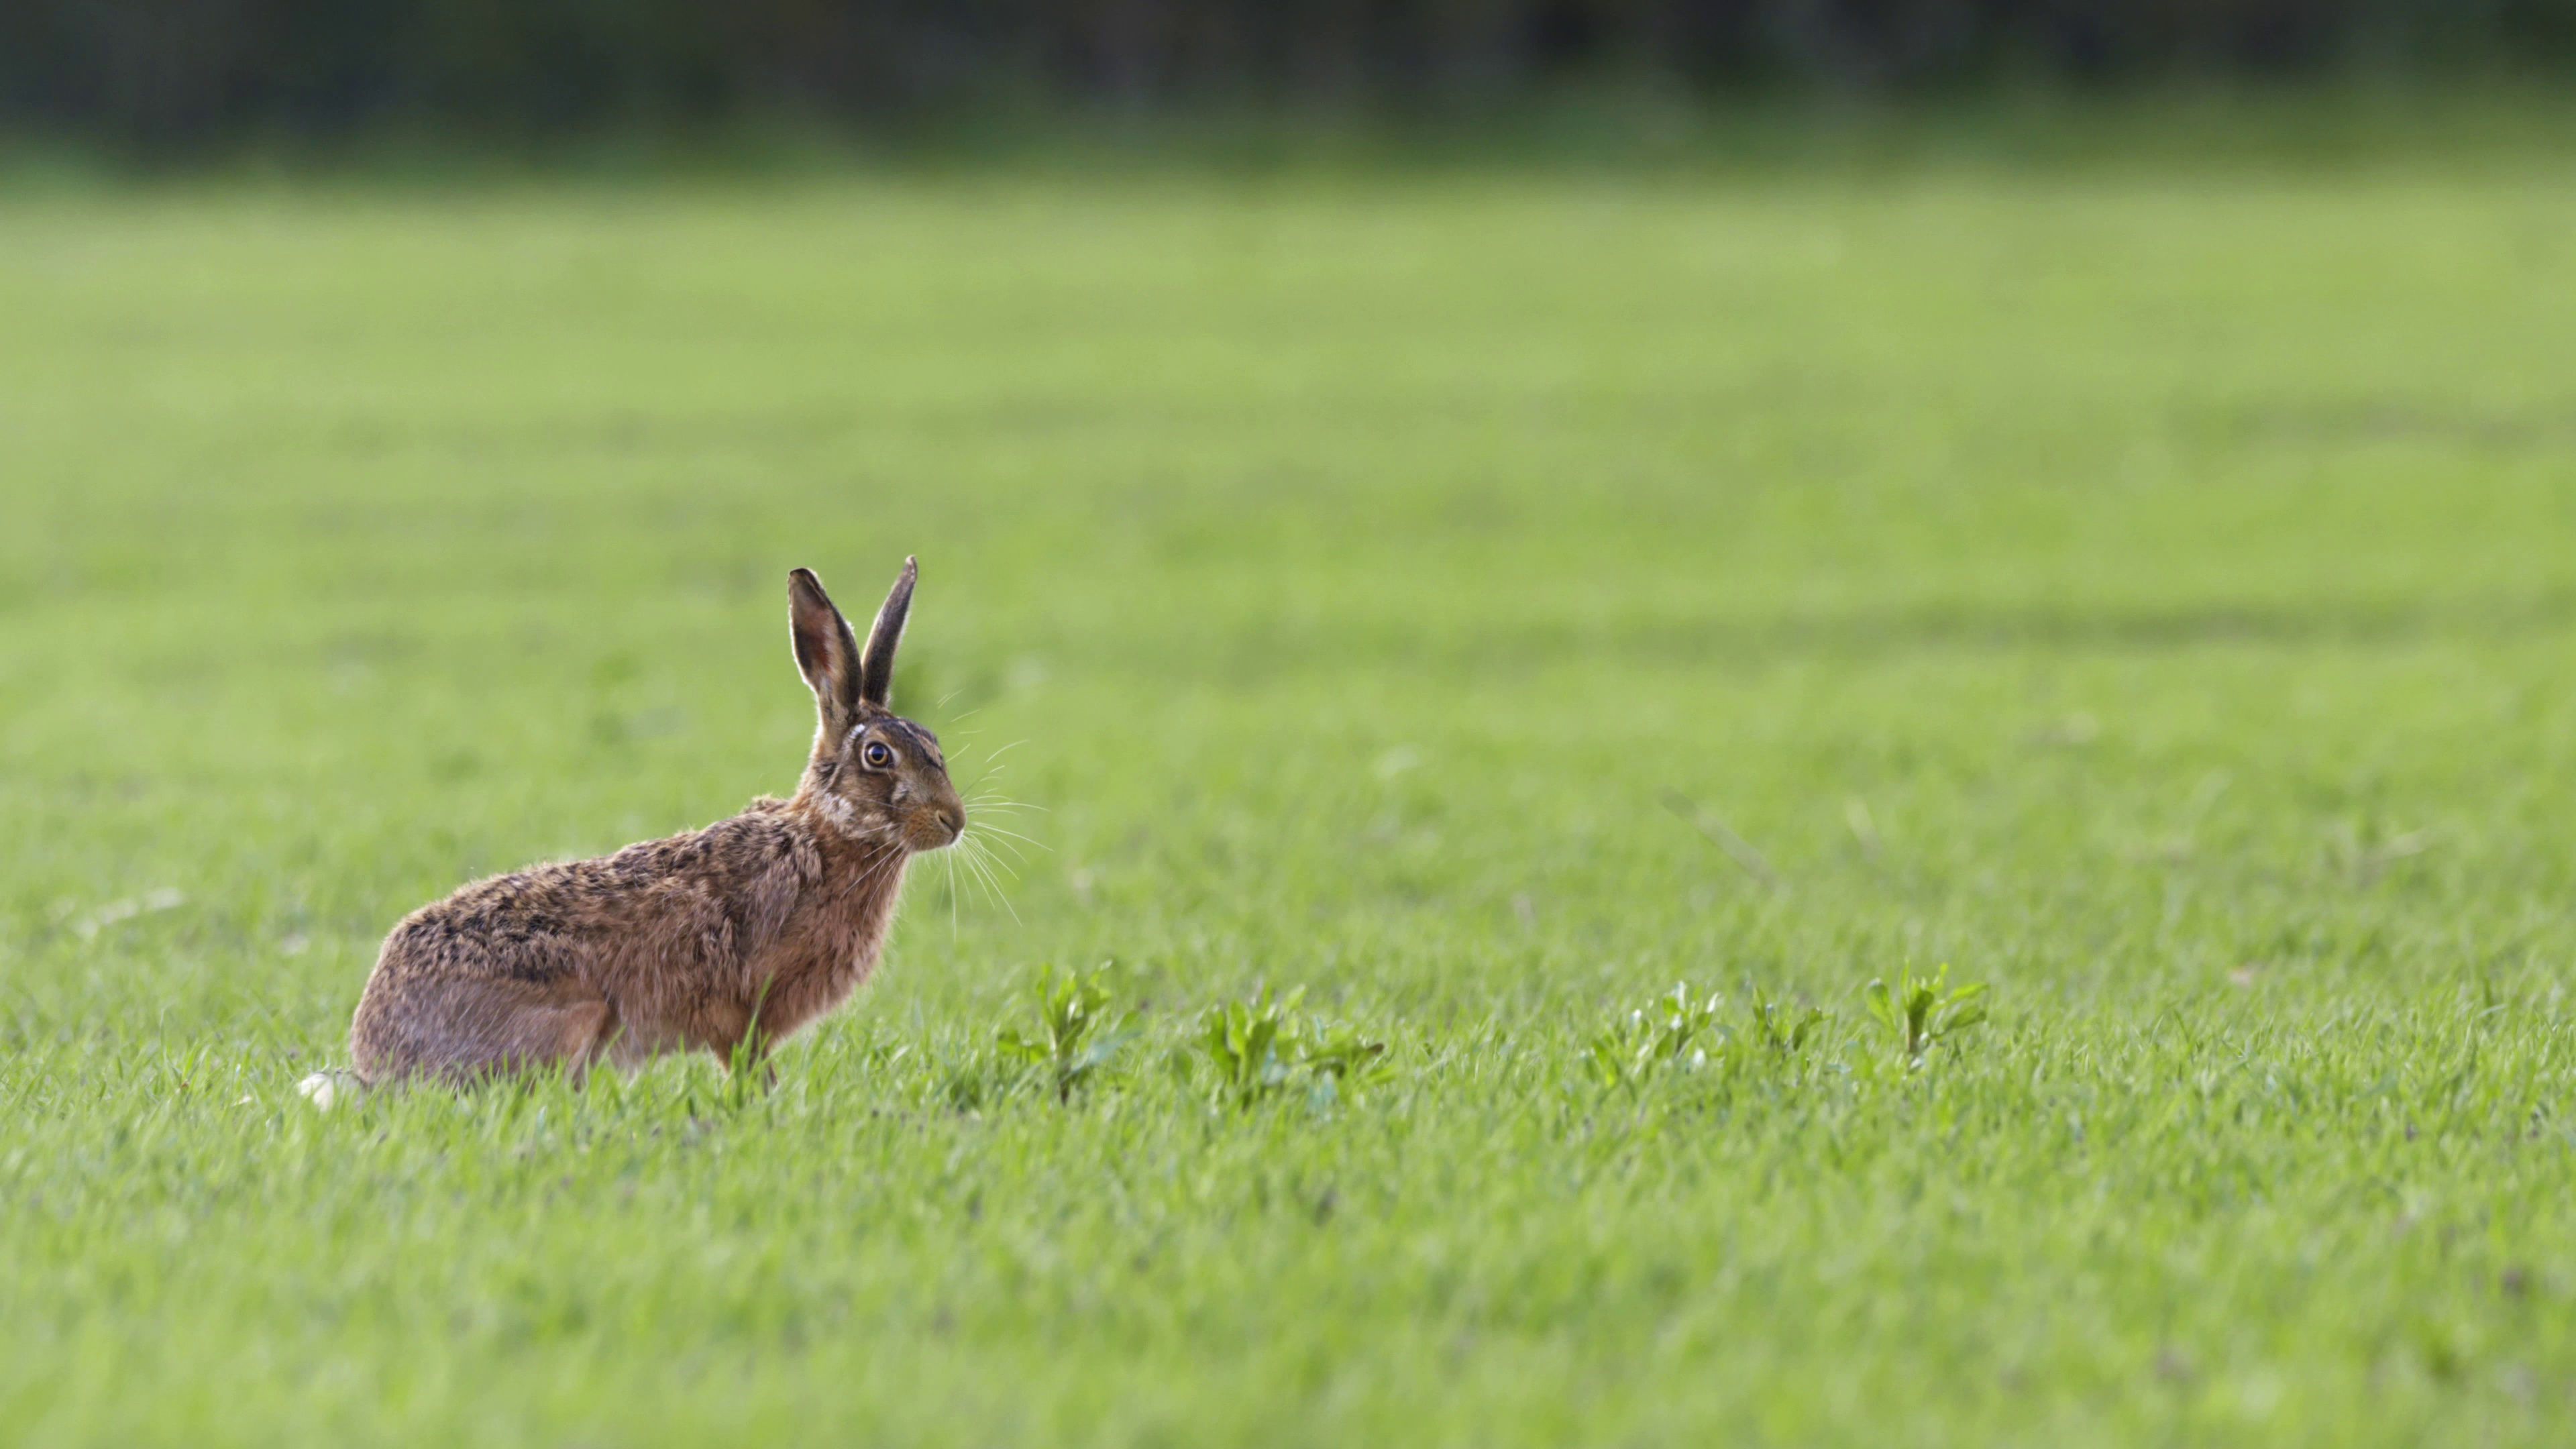

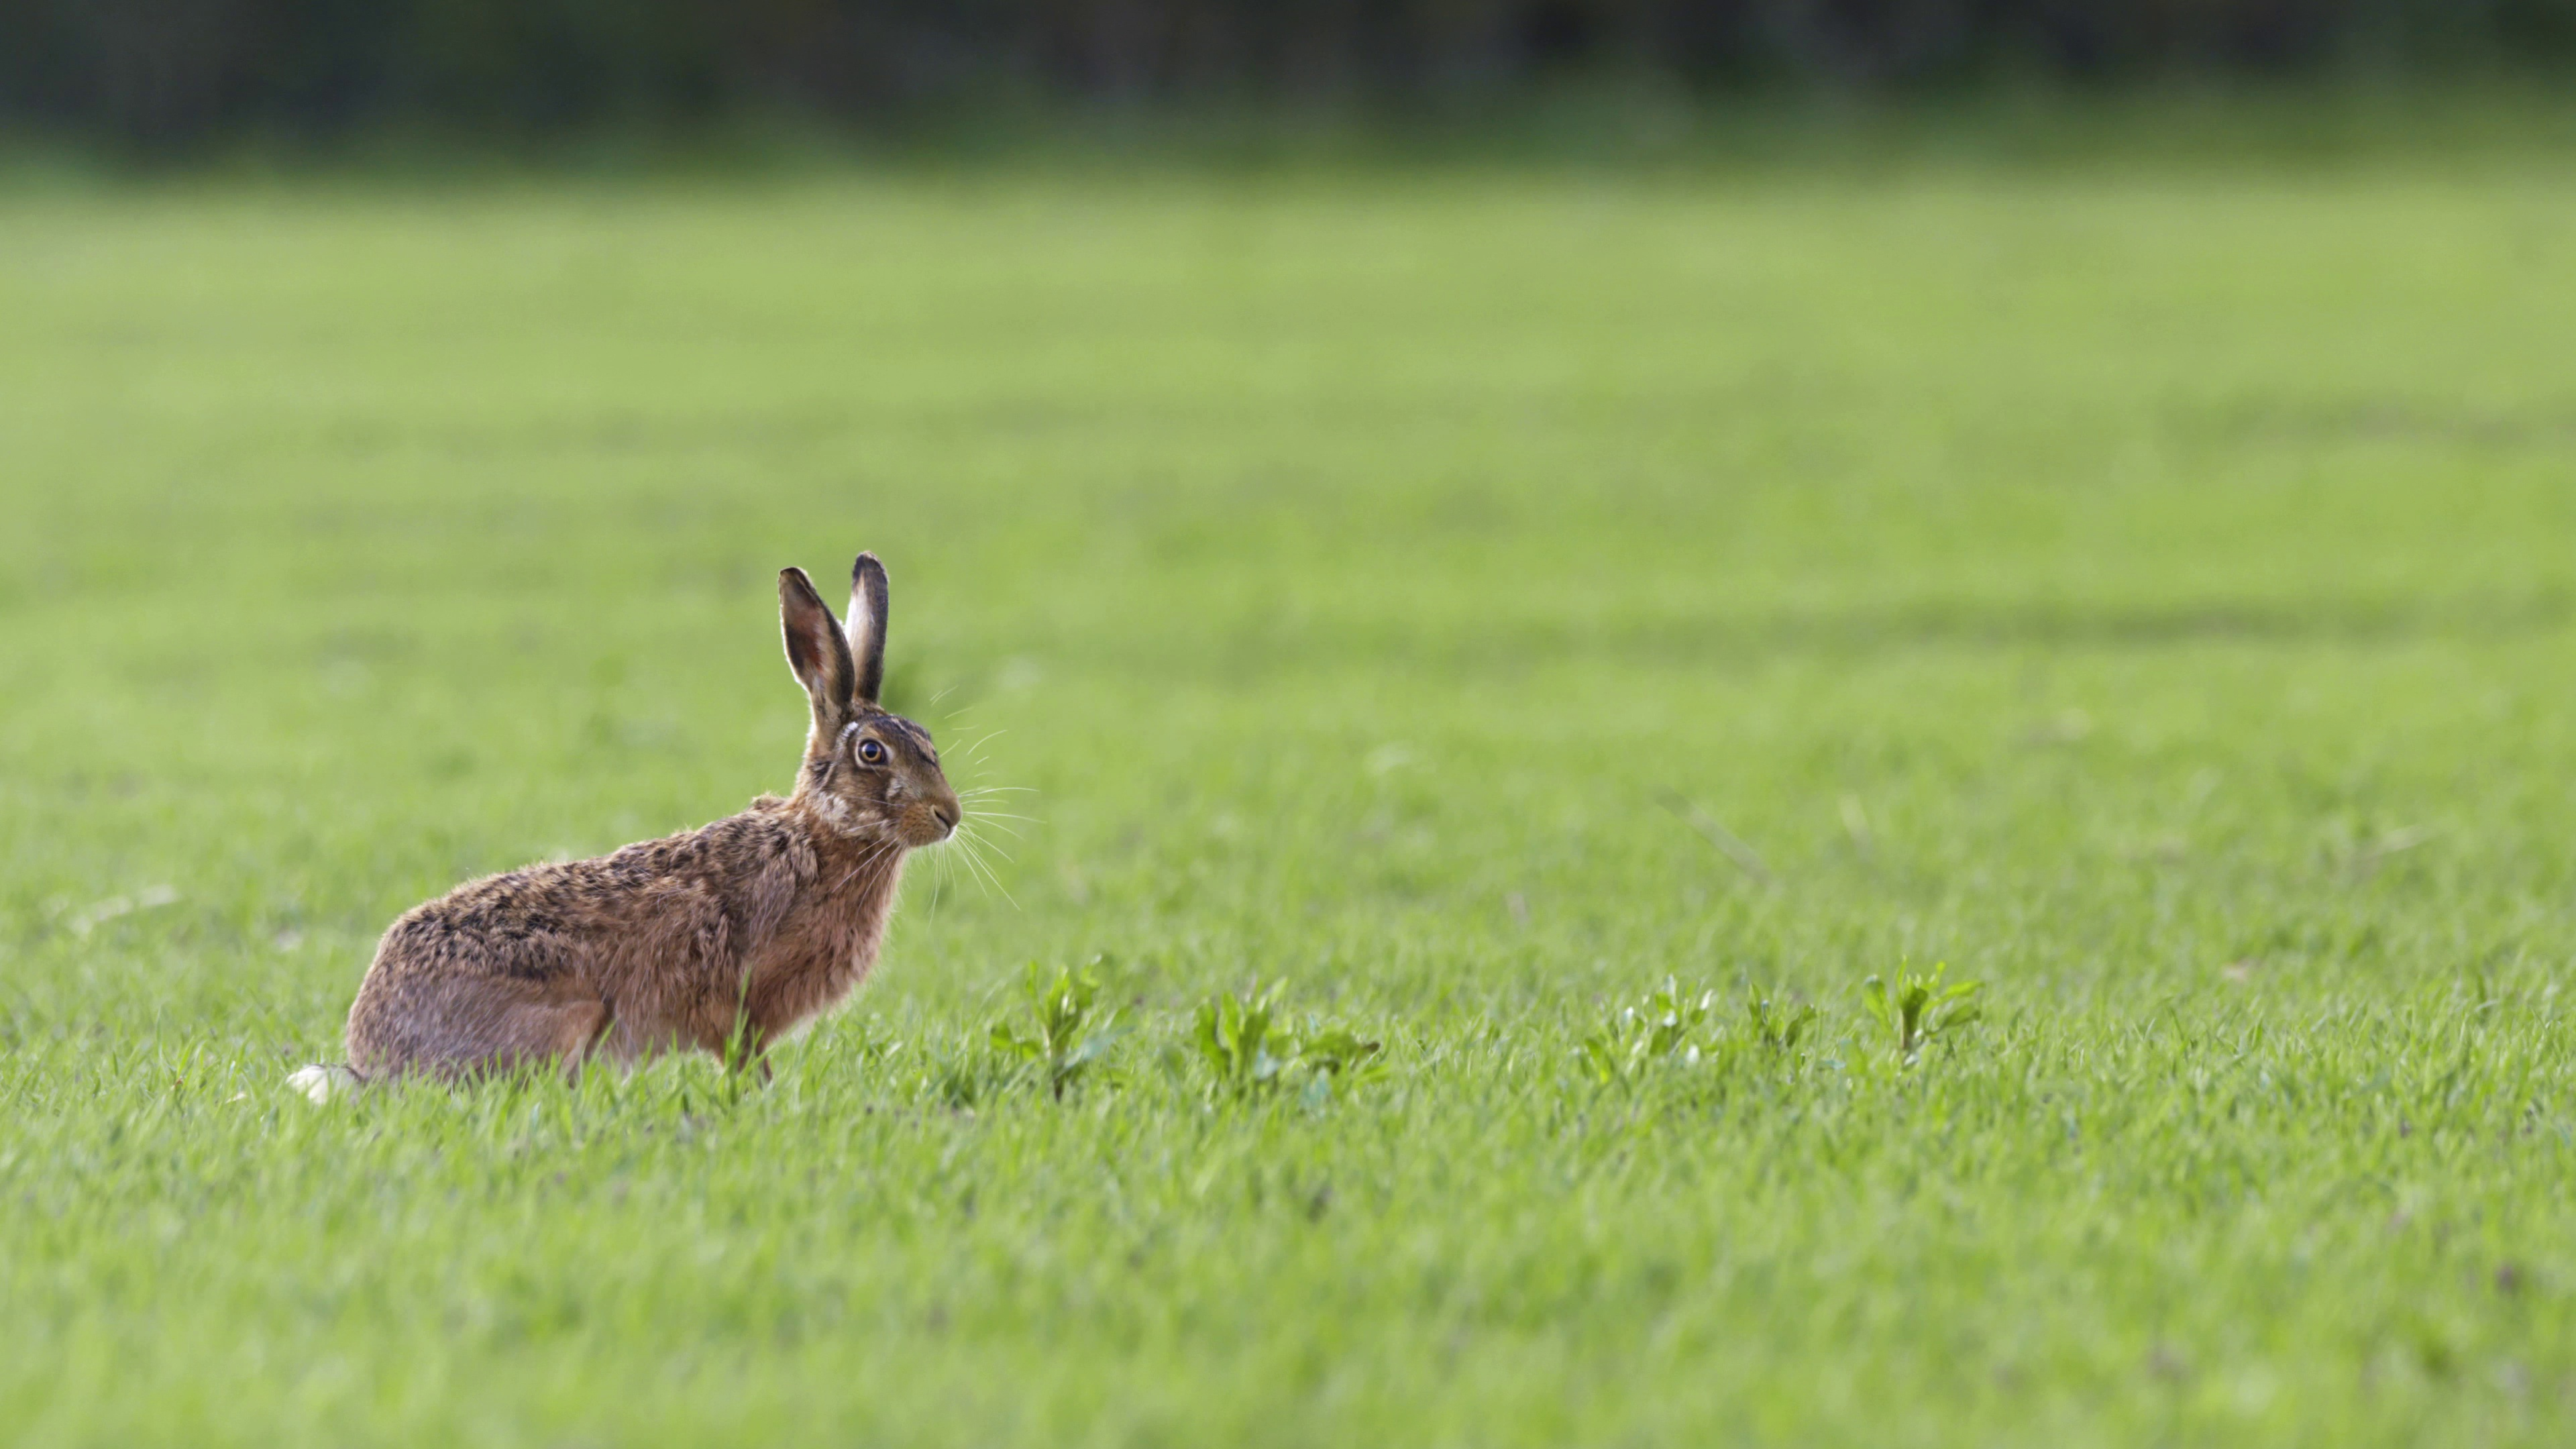

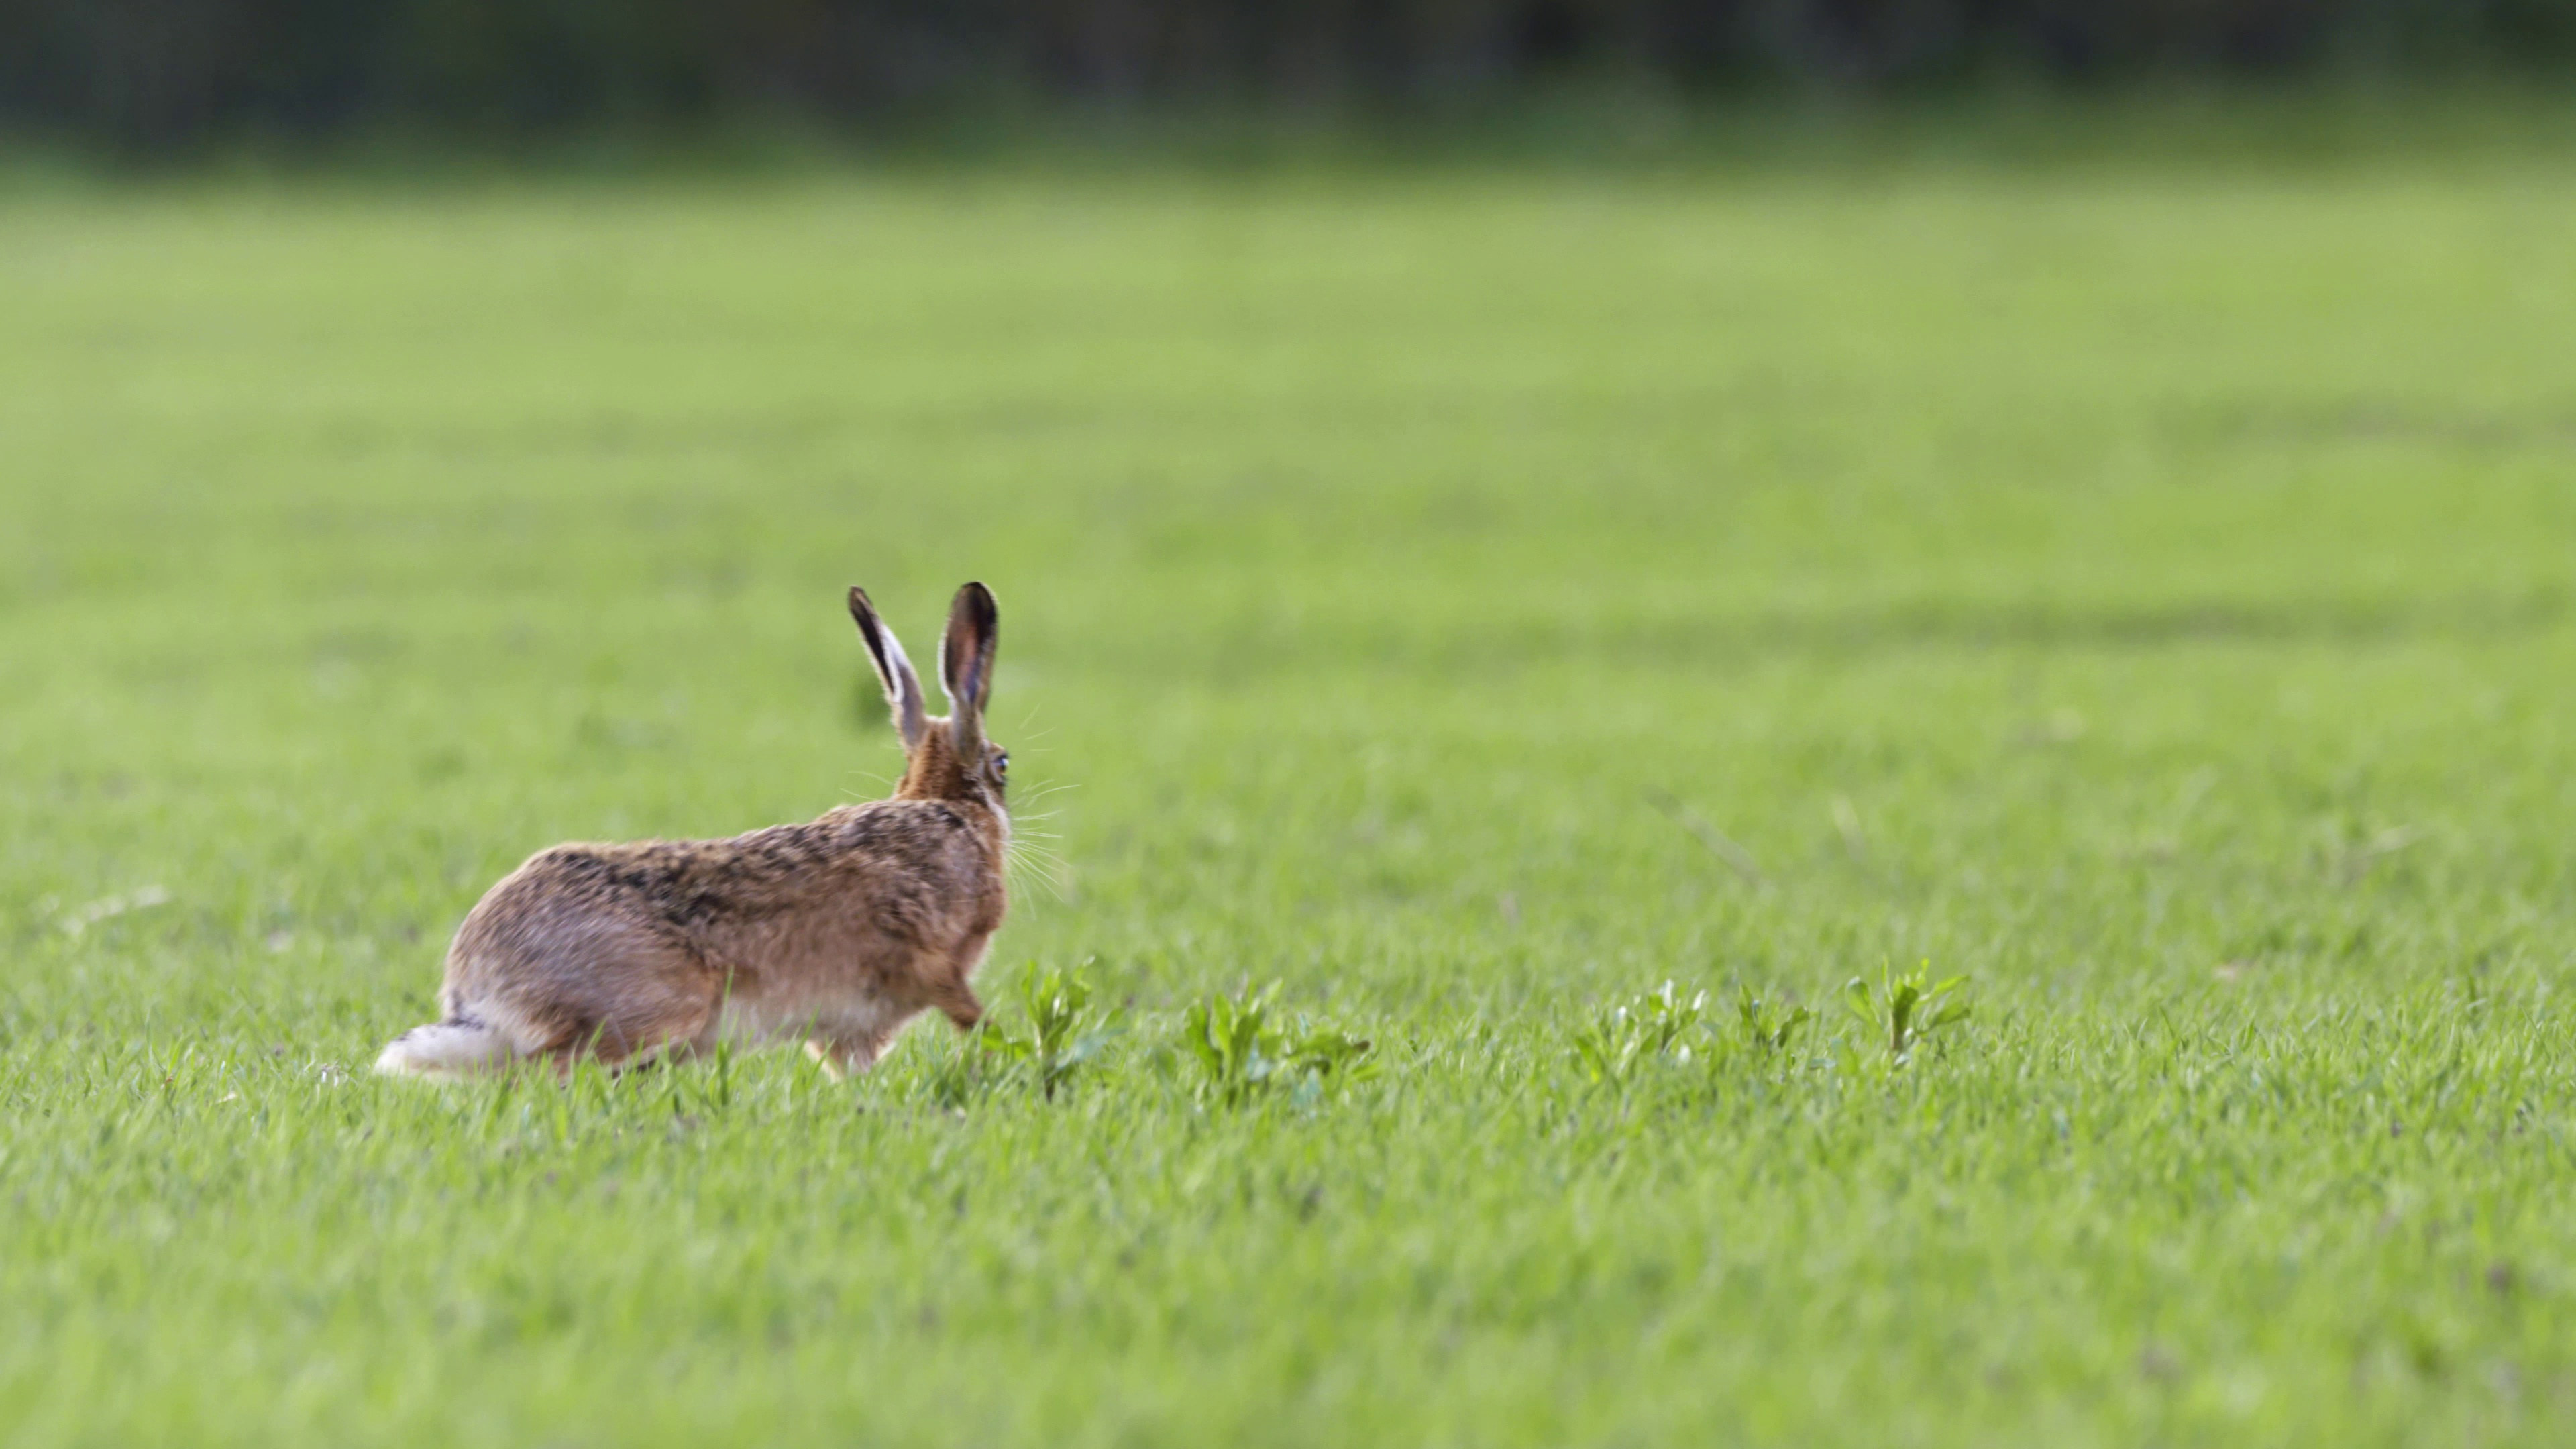

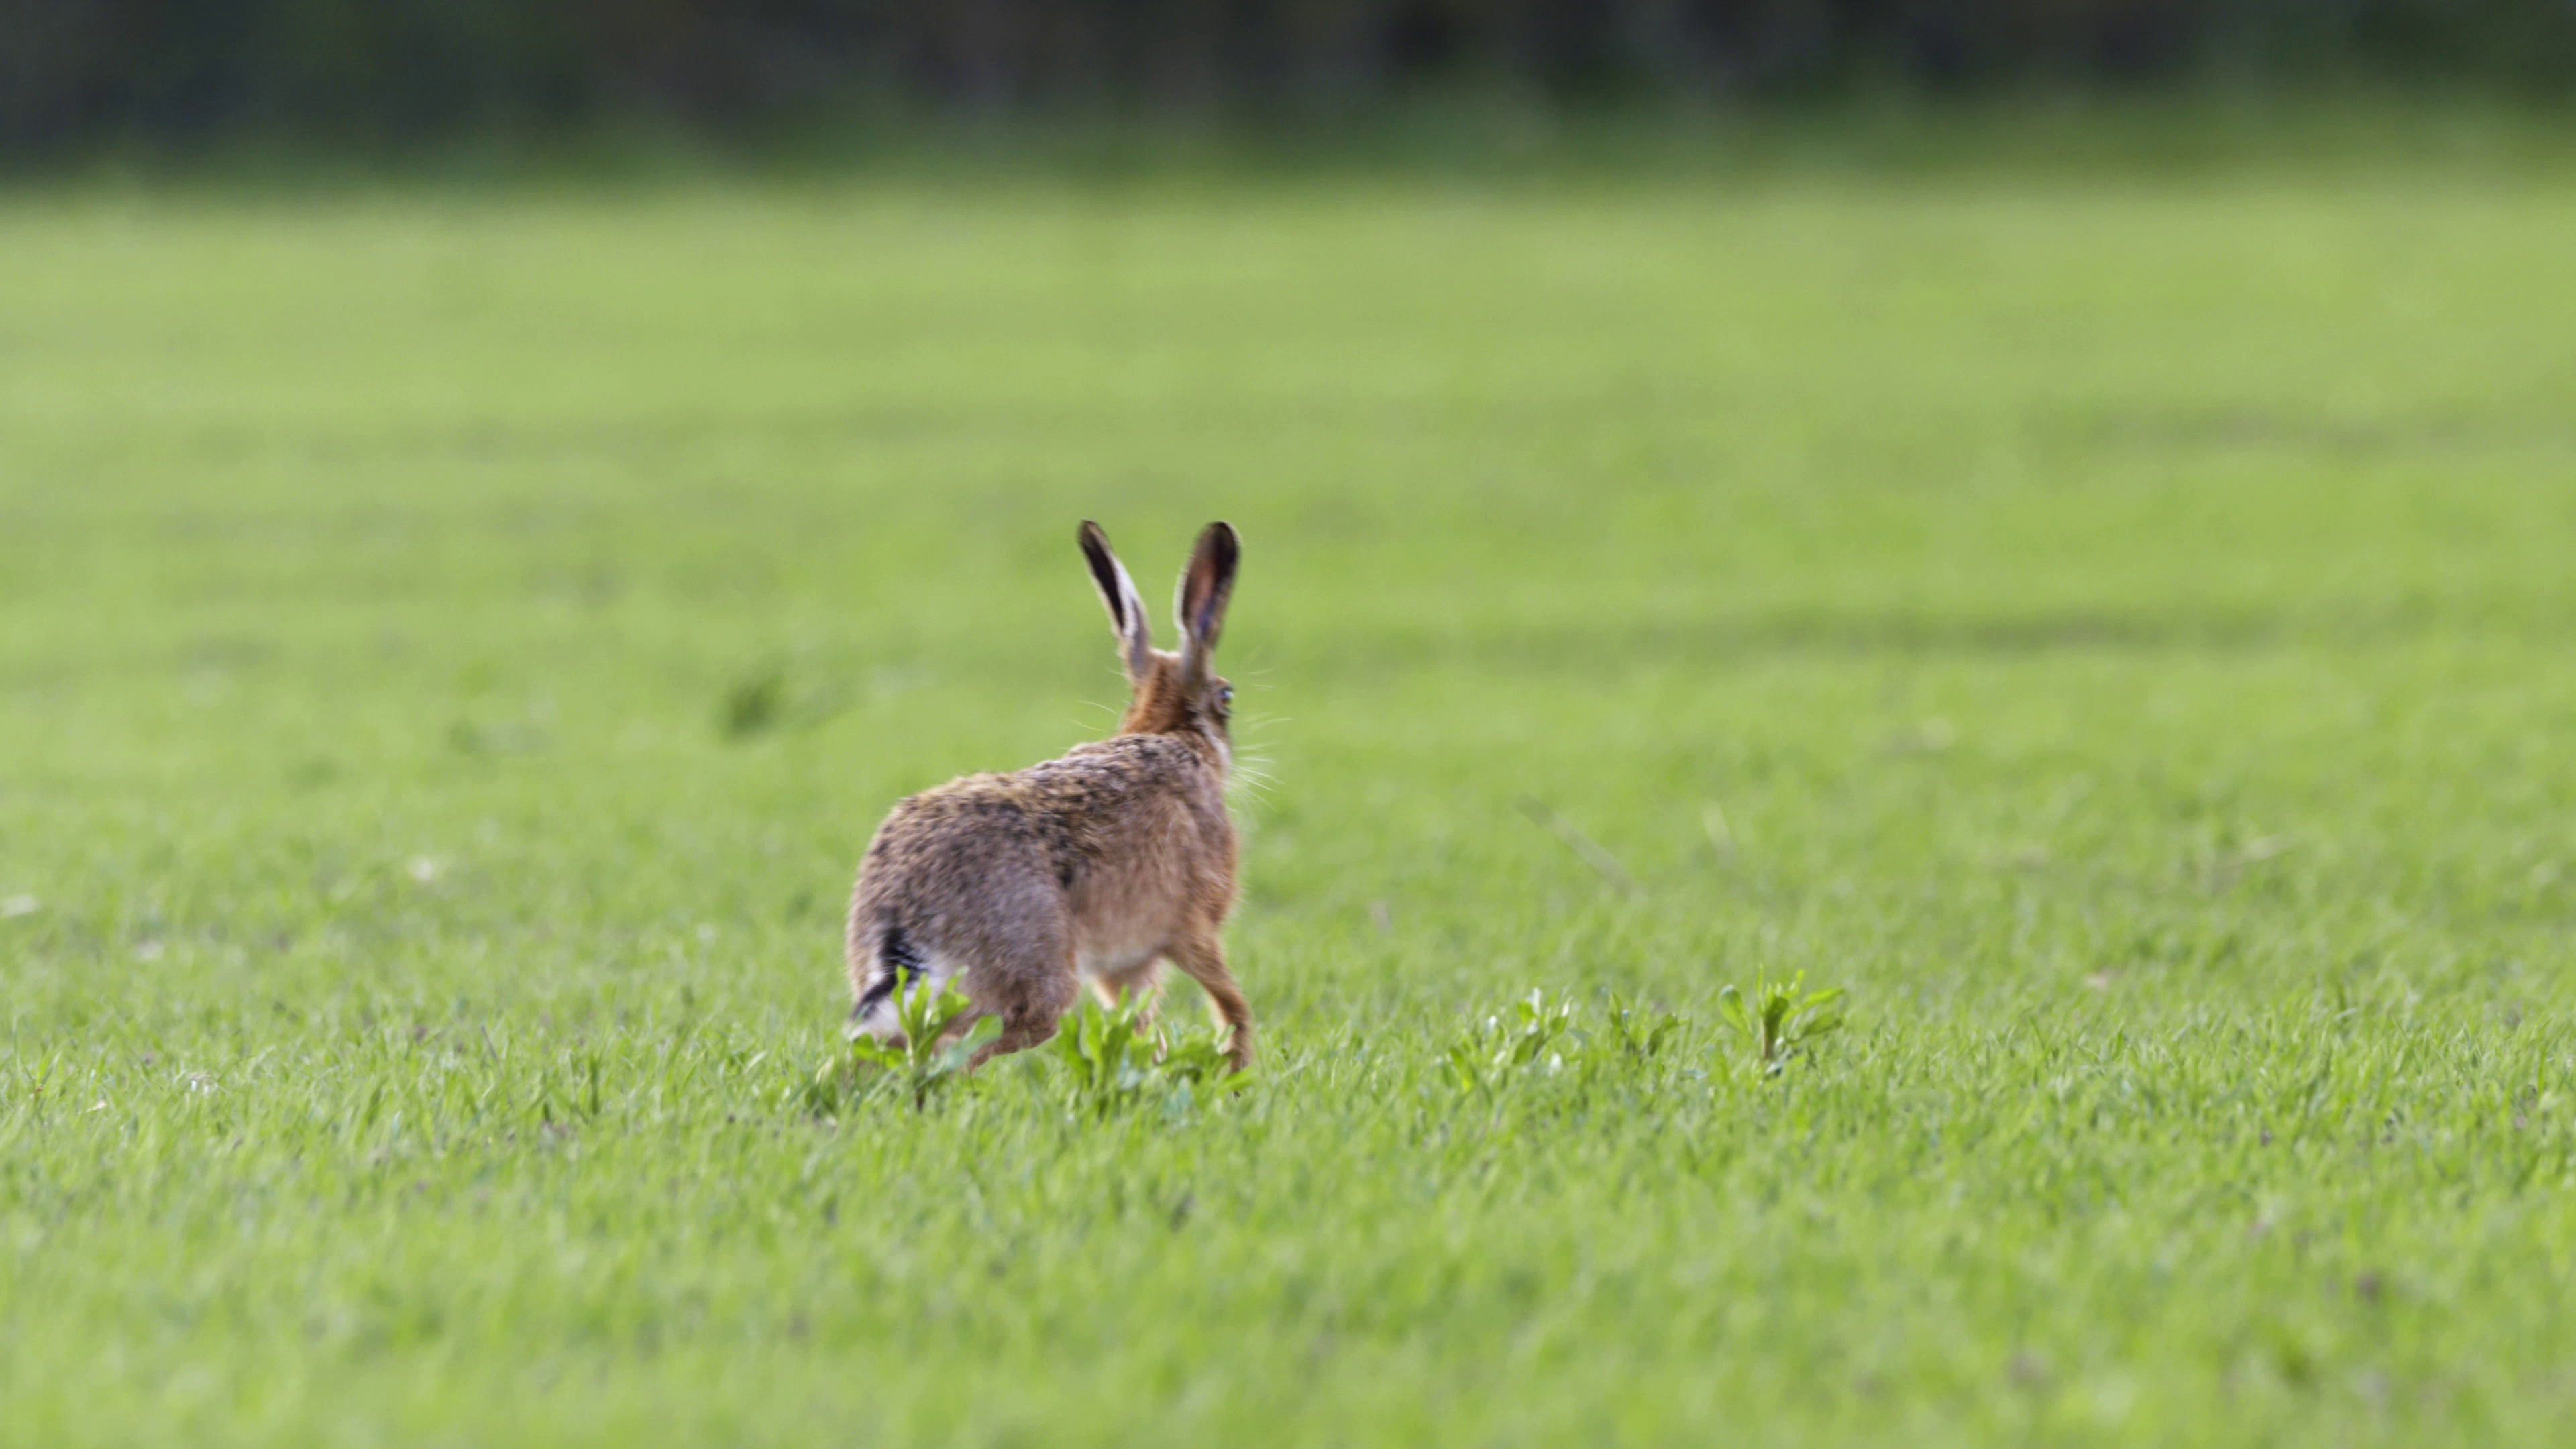

In [11]:
import os
from IPython.display import Image, display

# List all files in the current directory
for file in os.listdir():
    if file.startswith("keyframe"):
        display(Image(filename=file))


In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Visualization: Generating a heatmap for one of the frames
def generate_heatmap(model, processed_frame):
    last_conv_layer = model.get_layer('block5_conv3')  # Last convolutional layer for VGG16
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(processed_frame)
        class_idx = np.argmax(preds[0])  # Get the class index
        class_output = preds[0, class_idx]  # Correct the indexing here.

    
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [23]:
# Calculate classification metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('Confusion Matrix:')
    print(cm)

    return accuracy, precision, recall, f1, cm

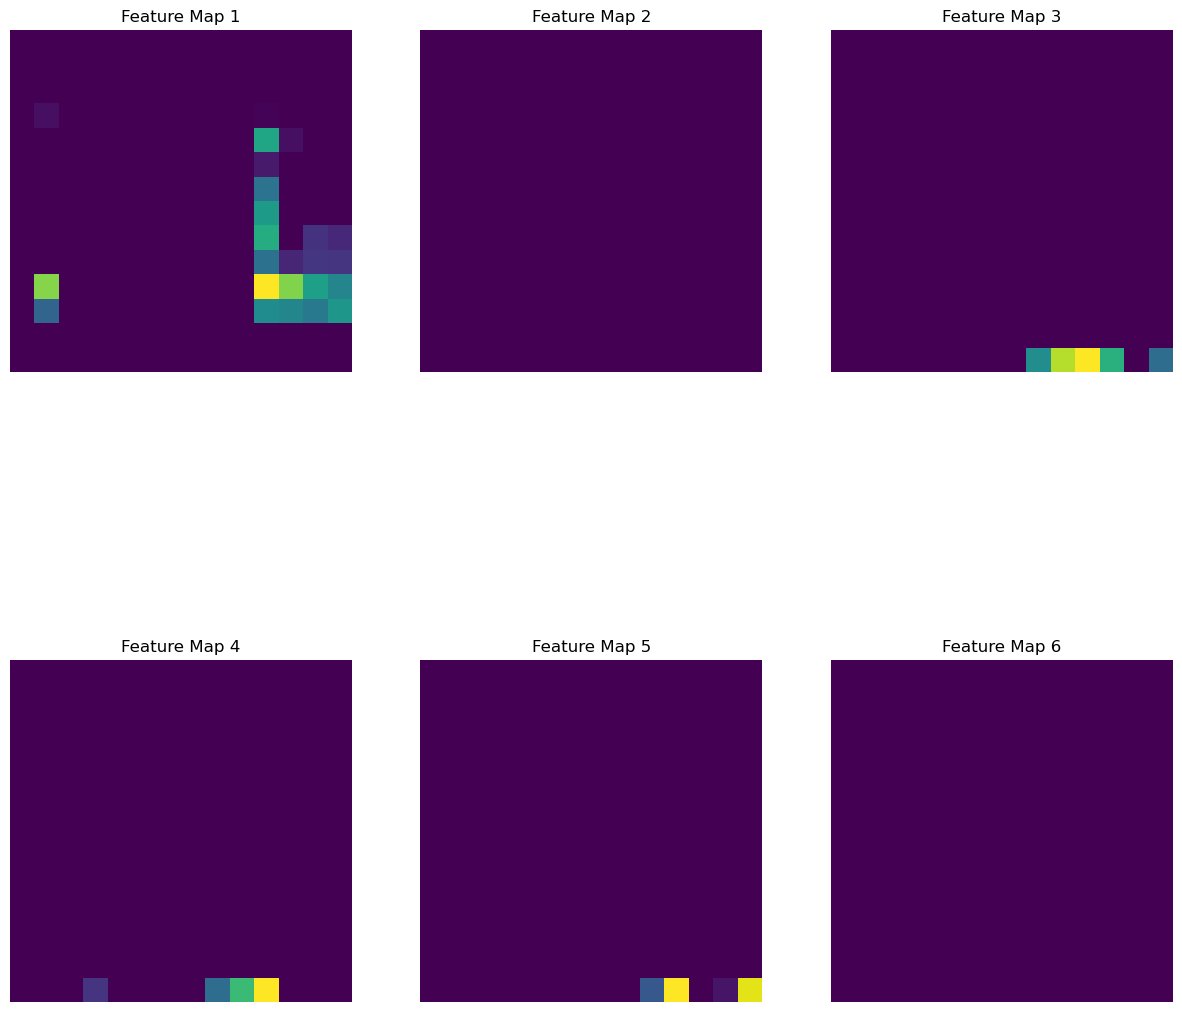

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def visualize_feature_maps(model, processed_frame, layer_name='block5_conv3'):
    # Ensure processed_frame is in correct shape and dtype
    processed_frame = tf.convert_to_tensor(processed_frame, dtype=tf.float32)
    
    # Extract the layer from which you want the feature maps
    layer_output = model.get_layer(layer_name).output

    # Create a model to get the feature maps
    feature_map_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)

    # Get the feature maps for the input image
    feature_maps = feature_map_model(processed_frame)

    # Convert the feature maps to numpy arrays
    feature_maps = feature_maps.numpy()

    # Visualize the first few feature maps (we'll display the first 6)
    num_feature_maps = feature_maps.shape[-1]  # Number of feature maps (channels)

    # Plot the feature maps
    plt.figure(figsize=(15, 15))
    for i in range(min(6, num_feature_maps)):  # Limit to 6 feature maps for visualization
        plt.subplot(2, 3, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map {i+1}')
    
    plt.show()


# Example Usage:
# Assuming processed_frame is the image you want to process, e.g., a preprocessed (224, 224, 3) image

# Assume cnn_model is already loaded (make sure to load your model appropriately)
cnn_model = create_cnn_model(model_name='vgg')  # Replace with actual model loading code
processed_frame = np.random.rand(1, 224, 224, 3)  # Example frame, replace with actual image input

# Visualize the feature maps
visualize_feature_maps(cnn_model, processed_frame)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


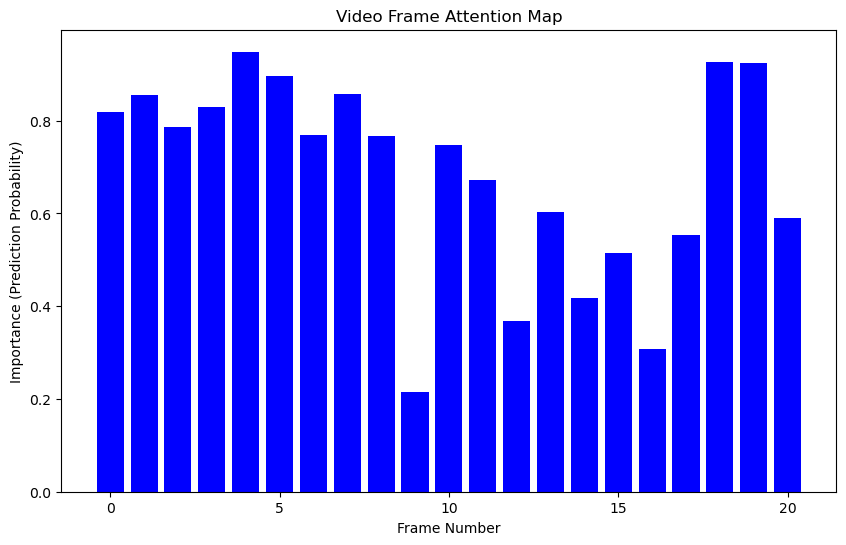

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to extract frames from a video
def extract_frames(video_path, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
    frame_interval = int(fps / frame_rate)  # Interval between frames
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        for _ in range(frame_interval-1):
            cap.grab()
    
    cap.release()
    return frames

# Function to preprocess and predict frame importance using CNN
def predict_frame_importance(frames, model):
    frame_importance = []
    for frame in frames:
        # Resize frame to fit model input shape
        img = cv2.resize(frame, (224, 224))  # For VGG16 input size
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        
        # Predict features
        preds = model.predict(img)
        
        # Extract class probabilities or another measure of importance
        importance = np.max(preds)  # Taking the highest predicted class probability
        frame_importance.append(importance)
    
    return frame_importance

# Function to display attention (importance) of each frame in the video
def visualize_frame_attention(frame_importance):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(frame_importance)), frame_importance, color='blue')
    plt.xlabel('Frame Number')
    plt.ylabel('Importance (Prediction Probability)')
    plt.title('Video Frame Attention Map')
    plt.show()

# Load pre-trained VGG16 model for feature extraction
model = VGG16(weights='imagenet')

# Extract frames from a sample video
video_path = 'Downloads/vid1.1.mp4'
frames = extract_frames(video_path, frame_rate=1)  # Extract 1 frame per second

# Predict importance for each frame
frame_importance = predict_frame_importance(frames, model)

# Visualize frame attention
visualize_frame_attention(frame_importance)



In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Example ground truth and predicted frames (1 for important, 0 for not important)
ground_truth = [1, 0, 1, 1, 0, 1, 0]  # Actual important frames
predicted_frames = [1, 0, 1, 0, 0, 1, 0]  # Predicted important frames

# Calculate metrics
precision = precision_score(ground_truth, predicted_frames)
recall = recall_score(ground_truth, predicted_frames)
f1 = f1_score(ground_truth, predicted_frames)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 1.0
Recall: 0.75
F1 Score: 0.8571428571428571
